## Cart Pole 

* The agent has to decide between two actions $\mathcal{A}=\{r,l\}$ moving to the right or moving to the left.
* Rewards: Better performing scenarios will run longer duration accumulating larger return.
  $$r_{t} = +1, s\in\mathcal{Q}$$
 where $\mathcal{Q}$ is the desired range of motion that is considered ideal for the agent. This ranges is not moving more than 2.4 units away from the center and not letting the pole fall over too far.
 * Agent inputs: 4 real values represent the environment state (position, velocty)

In [1]:
#Packages
import gym
import math
import random
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

#setting up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

#setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Buffer
* `Transition`: a named tuple that represents a transition in the environment $(s_t,a_t,r_t,s_{t+1})$
* `State`: since it is from pixels, the state is the screen difference image from the previous frame to the current frame
* `ReplayMemory`: is the stack that accumulates the transitions

In [2]:
Transition = namedtuple('Transition', ('state','action','next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        
    def push(self, *args):
        self.memory.append(Tansitions(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## DQN Algorithm


In [3]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)#conv (input_channels, output_channels, kernel, stride)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))# ??
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32   #32 are the amount of channels from the third conv layer
        self.head = nn.Linear(linear_input_size, outputs)
        
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))#functional ??
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1)) #?? view is like a reshape but dont create a copy
    


`x.view(x.size(0), -1)` is flattening the tensor, this is because the Linear layer only accepts a vector (1d array). To break it down, `x.view()` reshapes the tensor of the specified shape (more info). `x.shape(0)` returns 1st dimension of the tensor (which is the batch size, this should remain the constant). The -1 in `x.view()` is a filler, in other words, its dimensions that we don't know, so PyTorch automatically calculates it. 

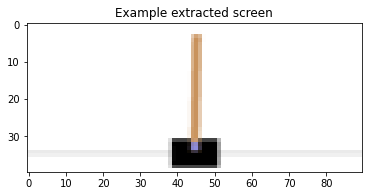

In [65]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Training
